## Refactoring Odes Function for Reduced ICs
> The goal of this NB is to reduce the number of ICs that must be passed in to the Odes function, with the overall goal of preventing sigma, v0, and tau from changing during the runs as these should be constants.  Sigma aprpoaching zero is responsible for the RunTimeWarning, and by removing the parameters from the y0 in odes, we can avoid this error.

> Furthermore, a second goal of this NB is to update the necessary functions such that the synaptic couplings dictionary is always filled, and in spaces where there are no connections, is just filled with zeros.  I.e. the new number of connections for each node is now NumNodes instead of NumNodes-1.

In [8]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import os.path

COLOR = 'grey'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

In [9]:
def I(t=0,vI=[0,0,0]):
    '''
    Determines the applied current, with respect to the HH model.  By default makes a square wave
    '''
    
    #Applied current
    t_start = vI[0]
    t_end = vI[1]
    amplitude = vI[2]
    
    applied_current = (t>=t_start)*(t<=t_end)*amplitude
    #Ie if t is within range [t_start,t_end], we apply some amount of current, amplitude
    #Recall: t>=C evaluates to a Boolean, which, when used numerically, is equivalent to 0 or 1
    return applied_current

In [32]:
def plot_vnmh(x,t,numNodes,vI,numGVs=3,gatingVars=False):
    '''
    Callable function for plotting V,n,m,h
    
    Params:
        x: Matrix, each column is one of the above variables
        t: Time vector for x axis
        numNodes:
        gatingVars:
    '''
    node_length = int(len(x)/numNodes)
    V = np.zeros((numNodes, len(t)))
    n = np.zeros((numNodes, len(t)))
    m = np.zeros((numNodes, len(t)))
    h = np.zeros((numNodes, len(t)))
    
    #plot the results
    plt.figure(figsize=(15,10))
    #Font sizes
    title_font = 20
    label_font = 15
    
    #Extract variables from matrix
    for node in range(numNodes):
        V[node] = x[node_length*node,:]
        n[node] = x[node_length*node+1,:]
        m[node] = x[node_length*node+2,:]
        h[node] = x[node_length*node+3,:]

    #Now plot the voltage graph:
    plt.title("Voltage as a Function of Time", fontsize=title_font, fontweight="bold")
    plt.ylabel("Volts (mV)", fontsize=label_font)
    plt.xlabel("Time (ms)", fontsize=label_font)
    for node in range(numNodes):
        NeuronNum = 'Neuron ' + str(node+1)
        plt.plot(t,V[node],label=NeuronNum)
    
    plt.axvspan(vI[0],vI[1],color='red',alpha=0.3)
    leg = plt.legend(loc='upper right')
    for text in leg.get_texts():
        text.set_color('black')
    plt.show()

    if gatingVars:
        plt.figure(figsize=(15,10))
        plt.title("Gating Variables as a Function of Time", fontsize=title_font, fontweight="bold")
        plt.ylabel("Volts (mV)", fontsize=label_font)
        plt.xlabel("Time (ms)", fontsize=label_font)
        
        #Should probably just plot n's together or something... otherwise too many curves on one plot
        my_label = [0]*numGVs
        for node in range(numNodes):
            my_label[0] = 'n' + str(node+1)
            my_label[1] = 'm' + str(node+2)
            my_label[2] = 'h' + str(node+3)
            
            plt.plot(t,n[node],label=my_label[0])
            plt.plot(t,m[node],label=my_label[1])
            plt.plot(t,h[node],label=my_label[2])
        
        plt.axvspan(vI[0],vI[1],color='red',alpha=0.3)
        leg = plt.legend(loc='upper right')
        for text in leg.get_texts():
            text.set_color('black')
        plt.show()

In [20]:
#Functions replacing non-functionalized calls from odes_sigmoid

def tau_func(V, mean):
    '''
    Function which returns the time constant for the associated variable
    Note that currently we are ignoring the "bump" in the true Tau functions and instead
    simply returning the mean.  The mean has been precalculated and will just be passed
    in and out for form's sake.
    
    In the future may switch to represent Tau functions as Gaussians (which they appear to be), but
    this would require extra parameters (i.e. instead of mean would need the center, width, and upwards bias)
    '''
    return mean


def inf_func(V, v0, sigma):
    '''
    Approximates the "quasi-Steady-State" ie the x_inf values, using sigmoid functions
    
    Params:
        v0: v initial value, changes x coord of center, essentially
        sigma: "rate" (technically 1/sigma is the rate) --> big sigma means gradual change (i.e. less steep slope)
    '''
    
    if v0==0 and sigma==0:
        #Avoid division by 0
        x_inf = 0
    else:
        x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
    return x_inf 


def diffEQ_func(tau, x_inf, x):
    '''
    ie dndt, dmdt, dhdt
    Uses the canonical self linear form, such that dxdt = G(x) * (E(x) - V)
    '''
    if tau==0:
        #Avoid division by 0
        dxdt = 0
    else:
        #for the base equations is just
        dxdt = (1/tau)*(x_inf - x)
    return dxdt

In [27]:
def set_parameters(numGVs,*args):
    #numv0s = numTaus = num sigmas = numGVs
    
    my_path = os.getcwd() + r"\\NetworkCouplingParams"
    filename = str(numGVs) + "GVs.txt"
    completeName = my_path + filename
    with open(completeName, "w+") as file_object:
        for GV in range(numGVs):
            v0 = args[0][GV*numGVs]
            sigma = args[0][GV*numGVs+1]
            tau = args[0][GV*numGVs+2]
            my_string = str(v0) + ", " + str(sigma) + ", " + str(tau) + "\n"
            file_object.write(my_string)
    numNodes = int(len(args)/3)
            

def get_parameters(numGVs):
    my_path = os.getcwd() + r"\\NetworkCouplingParams"
    filename = str(numGVs) + "GVs.txt"
    completeName = my_path + filename
    with open(completeName, "r") as file_object:
        param_list = [line.split(',') for line in file_object.readlines()]
    
    one_list = []
    for sublist in param_list:
        one_list = one_list + sublist
    one_list = ([item.strip('\n') and item.strip() for item in one_list])
    one_list = [float(val) for val in one_list]
    
    #This is done manually here...  Currently configured to support up to the 10 node case
    #This really ought to be done in the set_parameters...
    param_array = np.array([one_list,one_list,one_list,one_list,one_list,one_list,one_list,one_list,one_list,one_list])

    return param_array
    
    
def read_SC(node, numNodes):
    if numNodes==10:
        my_path = os.getcwd() + r"\\NetworkCouplingParams\\" + "x10_0_0.npy"
        my_array = np.load(my_path)
    else:
        filename = str(numNodes) + "Neurons.npy"
        my_path = os.getcwd() + r"\\NetworkCouplingParams\\" + filename
        my_array = np.load(my_path)
    
    my_string = str(my_array[node,:]) #-1
    #print(node)
    #print(my_string)
    my_string = my_string.replace('\n','')
    for char in my_string:
        if char in "[],\n/;:":
            my_string = my_string.replace(char,'')
    
    my_keys = [val+1 for val in range(numNodes)]
    my_vals = my_string.split()
    my_dict = {}
    count = 0
    for key in my_keys:
        my_dict[key] = my_vals[count]
        count += 1
    
    return my_dict


numGVs = 3
input_list = [-49,-36,-55,18,10,-8,2.785,0.258,2.810]
#set_parameters(numGVs,input_list)

output_array = get_parameters(numGVs)
#print(output_array)

In [39]:
def odes_RF(x,t,I,vI):
    '''
    Defines the constants and differential equations for the base Hodgkin-Huxley equations

    Params:: 
        x: all network parameters
        t: time vector, not called in func but regardless (but used in odeint)
        I: custom function, time varying current (square wave)
        vI: custom 3x1 vector for I function, just encapsulates the parameters needed for I to function

    Returns:: Differential equations of each variable as a vector
    '''
    
    ######### DEFINITIONS #########
    
    numGVs = 3 #This is "Manual" for now, could update the functionality to vary this
    p = [1,1+numGVs,-len(x)]
    roots = np.roots(p)
    numNodes = int(roots[1])
    
    param_array = get_parameters(numGVs)

    numSC = numNodes
    ES = [0] * numSC #ENa #mV #Excitatory Neuron (by this definition)
    node_current = [0]*numNodes
    
    #Convert list input into a matrix
    numParams = 1+numGVs+numSC
    x_list = x
    x = np.reshape(x,(numNodes,numParams))
    
    if len(x.shape)==1:
        #Ie if it is 1D, expand the dim to be (1,X) so that we can index as if it were 2D
        x = np.expand_dims(x,0)
        
    firstSIndex = 1+numGVs
    
    infs = np.zeros((numNodes,numGVs))
    taus = np.zeros((numNodes,numGVs))
    dxdts = np.zeros((numNodes,numParams))

    ######### CONSTANTS #########
    CmBase = 0.01 #uF
    #Altering the current for the nodes, essentially weighting them
    #In the test trials in NB 10, we used 1x for node1, and 0x for node2
    
    #Current weighting matrix
    node_current[0] = 1
    if numNodes>1:
        #Do something more advanced later
        node_current[1] = 0
    node_current = np.array(node_current)*(1/CmBase)
    
    #For the synaptic coupling: 
    #^20 was a "good value" (ie one for which it functioned) in the previous NB
    gbars = [20] * numSC
    
    ######### LOOPING #########
    
    for nodeTemp in range(numNodes): 
        #Weighting matrix
        #get_WM(numNodes)
        #Defining 10 individual neurons
        #WM = np.array([[0.95, 0.89, 1.1, 1.03, 1.04, 0.99, 0.93],[1.17, 0.97, 0.92, 1.1, 1.23, 0.91, 0.95],[0.88, 0.97, 0.95, 0.93, 0.99, 0.89, 0.92],[1.02, 1.03, 1.04, 0.99, 1.02, 0.91, 1.05],[1.06, 0.97, 1.07, 1.04, 0.94, 1.03, 0.93],[1.02, 1.03, 0.99, 1.01, 1.04, 0.99, 0.98],[0.92, 0.98, 1.06, 0.92, 0.92, 1.02, 1.01],[0.9, 1.1, 1.1, 0.93, 0.93, 1.1, 0.93],[1.03, 1.09, 1.02, 1.01, 1.02, 1.09, 1.03],[1.05, 0.99, 0.98, 0.97, 0.99, 1.02, 0.99]])
        WM = np.array([[0.95, 0.89, 0.89, 0.94, 0.94, 0.99, 0.93],[0.88, 0.97, 0.92, 0.91, 0.93, 0.91, 0.95],[0.88, 0.97, 0.95, 0.93, 0.99, 0.89, 0.92],[0.95, 0.98, 0.89, 0.99, 0.92, 0.91, 0.95],[0.96, 0.97, 0.97, 0.84, 0.94, 0.93, 0.93],[0.82, 0.83, 0.99, 0.81, 0.84, 0.99, 0.98],[0.92, 0.98, 0.86, 0.92, 0.92, 0.92, 0.91],[0.9, 0.81, 0.81, 0.93, 0.93, 0.91, 0.93],[0.93, 0.99, 0.92, 0.91, 0.92, 0.99, 0.93],[0.95, 0.99, 0.98, 0.97, 0.99, 0.82, 0.99]])
        
        #Source: https://www.math.mcgill.ca/gantumur/docs/reps/RyanSicilianoHH.pdf
        #reversal potentials
        ENa = 55.17*WM[nodeTemp,0] #mV
        EK = -72.14*WM[nodeTemp,1] #mV
        EL = -57.99*WM[nodeTemp,2] #-49.42 #mV
        #E4
        #E5
        #membrane capacitance
        Cm = CmBase*WM[nodeTemp,3] #uF/cm^2
        
        #conductances (S is Siemens)
        gbarK = 0.36*WM[nodeTemp,4] #mS/cm2
        gbarNa = 1.2*WM[nodeTemp,5] #mS/cm2
        gbarL = 0.003*WM[nodeTemp,6] #mS/cm2
        #So really there should be other values here for the 4th and 5th gating variables should those get used
        #gbar?(4) = ___
        #gbar?(5) = ___

        #For now, defining every neuron the same, but can change the "n,m,h" values...
        gK = (1/Cm)*gbarK*(x[nodeTemp,1]**4) #Why did I have a +maxParams after the 1?
        gNa = (1/Cm)*gbarNa*(x[nodeTemp,2]**3)*x[nodeTemp,3]
        gL = (1/Cm)*gbarL
        #Again, would need to add something for the 4th and 5th gating variables should they exist
        #...
        
        #Simplification: check connection in external function
        vnode_couplings = []
        svars = []   
        if numNodes==1:
            svars = [0]*numSC #1 neuron, so no connections.  Just return 0s
        else:
            SC_repo = read_SC(nodeTemp,numNodes) #RETURNS A DICTIONARY

            if SC_repo is not None and len(SC_repo)>0:
                for idx in range(numNodes):
                    idx += 1 #Adjust for offset, first node is 1 not 0
                    if SC_repo.get(idx) is not None:
                        adj_idx = int(idx)-1
                        vnode_couplings.append(adj_idx) #This is the node that it is coupled to
                        sval = float(SC_repo.get(idx))
                        svars.append(sval) #This is the s val, to be used in gs
            else:
                print("Error: SC_repo returned None")
                
        my_zeros = [0]*(firstSIndex)
        svars_full = my_zeros+svars
        vnode_couplings_full = my_zeros+vnode_couplings
        gs = np.array(gbars) * np.array(svars) #* (1/Cm)

        #Define the steady state (inf) values, and the time constants (tau)
        #Note that this must be completed first, so that all the taus, infs are defined before we can make the ODEs
        for param in range(numGVs):
            #inf(V, v0, sigma)
            infs[nodeTemp,param] = inf_func(x[nodeTemp,0], param_array[nodeTemp,param], param_array[nodeTemp,numGVs+param])
            #tau(V, mean)
            taus[nodeTemp,param] = tau_func(x[nodeTemp,0], param_array[nodeTemp,2*numGVs+param])

        #Define each ODE    
        for param in range(numParams): 
            if param==0:
                #dVdt = (gNa*(ENa-V) + gK*(EK-V) + gL*(EL-V) + gs1*(ES1-Va) + ... + gsn*(ESn-Vz) + I(t,vI))
                
                #TERM 1
                ionChannels = gNa*(ENa-x[nodeTemp,0]) + gK*(EK-x[nodeTemp,0]) + gL*(EL-x[nodeTemp,0])
                
                #TERM 2
                synCoups = 0
                for idx in range(numSC):
                    synCoups += gs[idx]*(ES[idx]-x[nodeTemp,0])
                    #^ Terms: (conducance gs_x) * (ES - V)

                #TERM 3
                appliedCurrent = I(t,vI)*node_current[nodeTemp]

                dxdts[nodeTemp,param] = ionChannels + synCoups + appliedCurrent
            elif param<(numGVs+1): #ie the gating variables
                #Note we use [nodeTemp,param-1] because there is no tau/inf for V so the matrix tau starts with n @ index 0
                dxdts[nodeTemp,param] = diffEQ_func(taus[nodeTemp,param-1], infs[nodeTemp,param-1], x[nodeTemp,param]) 
            elif param>=firstSIndex and sum(svars_full)==0: #ie if all the s vars are equal to zero
                break #ie just leave them as zero, and we are done with the loop so we can just break
            elif param>=firstSIndex:
                
                #STILL MANUAL
                tau_s = 30 #ms
                s_inf = 10.0/11.0 
                beta_s = 1/tau_s
                
                if numNodes==1:
                    pass #ie dsdts remain zeros
                else:
                    s = svars_full[param]
                    if s==0:
                        #Not sure if this will ever happen
                        #Goal is to get around cases where no s is passed in so s is 0
                        #^Maybe initilize that array to something biophysically impossible (e.g. can s be neagtive?)
                        dxdts[nodeTemp,param] = 0 
                    else:
                        coupled_neuron = vnode_couplings_full[param]
                        #coupled_neuron-1 because Neuron 1 corresponds to row 0
                        alpha_s = (x[coupled_neuron-1,0]>0)*(1/tau_s)

                        dxdts[nodeTemp,param] = alpha_s*(1-s)-beta_s*s 
                
                #This should be the last case, it will run once the way it currently configured
                #break
            else:
                pass
                #Should just be equal to zero, so leave as is (matrix is initialized as zeros)
    
    #Rearrange dxdts into a list so that we can unpack it
    flat_array = dxdts.flatten()
    ODE_list = flat_array.tolist()
    
    return ODE_list

In [40]:
V1 = -58; n1 = 0.05; m1 = 0.33; h1 = 0.6
node1Base = [V1, n1, m1, h1]
t = np.linspace(0,100,2000)

def runSim(vI,numNodes=1,plot_BI=True,plot_final=True,useCurrent=True,showGVs=False,isVerbose=0,my_tol=1.49012e-8):
    print("Burn in run, looking for NO oscillations")
    node1 = node1Base + ([0]*(numNodes))
    network_params = node1*numNodes #Letting all nodes be the same
    if isVerbose:
        x, my_verbosity = odeint(odes_RF,network_params,t,full_output=isVerbose,rtol=my_tol,args=(I,[0,0,0]))
        print(my_verbosity)
    else:
        x = odeint(odes_RF,network_params,t,full_output=isVerbose,rtol=my_tol,args=(I,[0,0,0]))
    x = np.transpose(x)
    if plot_BI:
        plot_vnmh(x,t,numNodes,[0,0,0],gatingVars=showGVs)
    #Now grab the burned in values from the previous run
    network_params_BI = x[:,-1]
    print("Burn in complete")
    
    print("Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected")
    #BURNED IN initial condition
    #if useCurrent:
    #    vI = [5,7,0.1]
    if isVerbose:
        x, my_verbosity = odeint(odes_RF,network_params_BI,t,rtol=my_tol,full_output=isVerbose,args=(I,vI))
        print(my_verbosity)
    else:
        x = odeint(odes_RF,network_params_BI,t,full_output=isVerbose,rtol=my_tol,args=(I,vI))
    x = np.transpose(x)
    if plot_final:
        plot_vnmh(x,t,numNodes,vI,gatingVars=showGVs)
    return x

In [30]:
def read_SC(node, numNodes):
    if numNodes==10:
        my_path = os.getcwd() + r"\\NetworkCouplingParams\\" + "x10_18_0.npy"
        my_array = np.load(my_path)
    else:
        filename = str(numNodes) + "Neurons.npy"
        my_path = os.getcwd() + r"\\NetworkCouplingParams\\" + filename
        my_array = np.load(my_path)
    
    my_string = str(my_array[node,:]) #-1
    #print(node)
    #print(my_string)
    my_string = my_string.replace('\n','')
    for char in my_string:
        if char in "[],\n/;:":
            my_string = my_string.replace(char,'')
    
    my_keys = [val+1 for val in range(numNodes)]
    my_vals = my_string.split()
    my_dict = {}
    count = 0
    for key in my_keys:
        my_dict[key] = my_vals[count]
        count += 1
    
    return my_dict

## Actual Runs

Burn in run, looking for NO oscillations


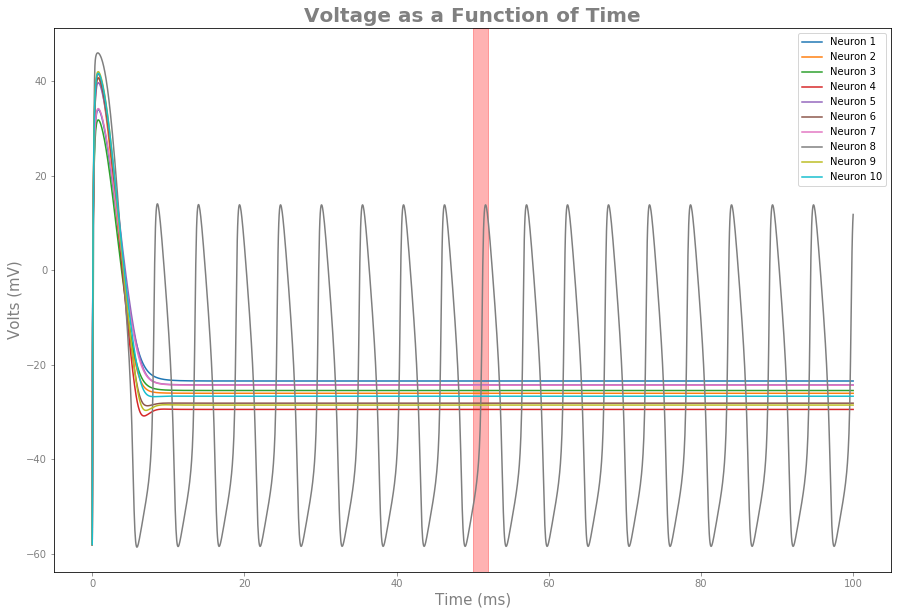

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


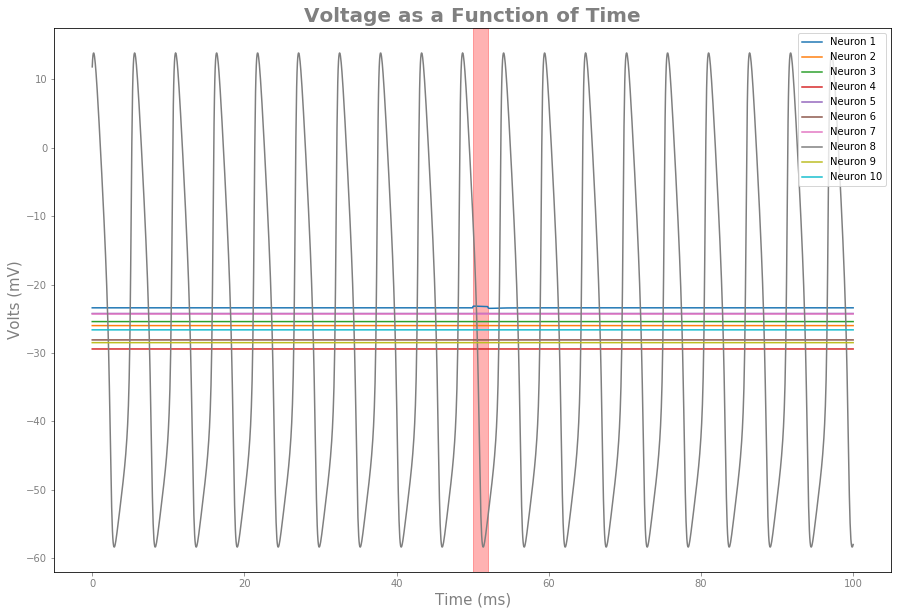

In [35]:
#"x10_9_0.npy"
def read_SC(node, numNodes):
    if numNodes==10:
        my_path = os.getcwd() + r"\\NetworkCouplingParams\\" + "x10_9_0.npy"
        my_array = np.load(my_path)
    else:
        filename = str(numNodes) + "Neurons.npy"
        my_path = os.getcwd() + r"\\NetworkCouplingParams\\" + filename
        my_array = np.load(my_path)
    
    my_string = str(my_array[node,:]) #-1
    #print(node)
    #print(my_string)
    my_string = my_string.replace('\n','')
    for char in my_string:
        if char in "[],\n/;:":
            my_string = my_string.replace(char,'')
    
    my_keys = [val+1 for val in range(numNodes)]
    my_vals = my_string.split()
    my_dict = {}
    count = 0
    for key in my_keys:
        my_dict[key] = my_vals[count]
        count += 1
    
    return my_dict

vI = [50,52,0.1]
updatedCurrent1 = runSim(vI,numNodes=10,plot_BI=True)

Burn in run, looking for NO oscillations


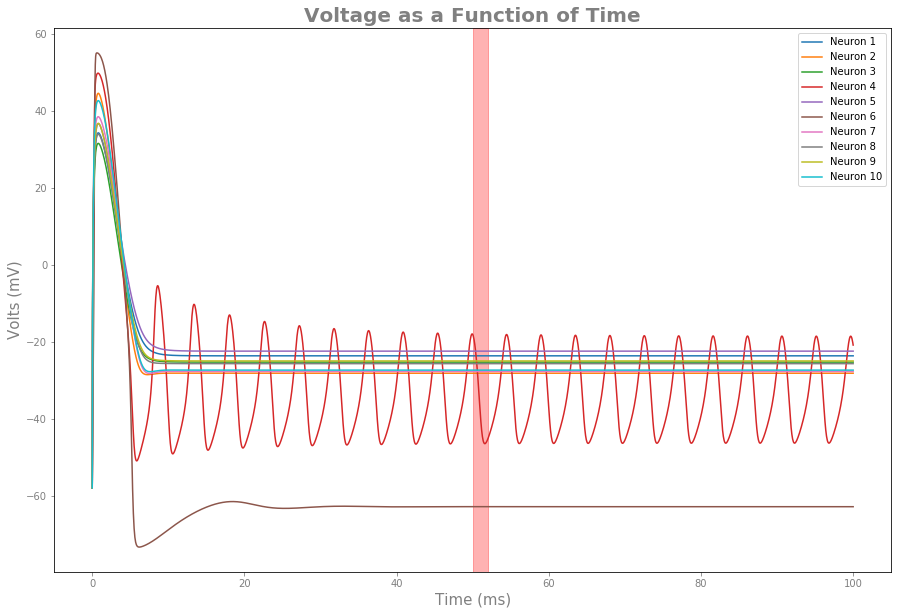

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


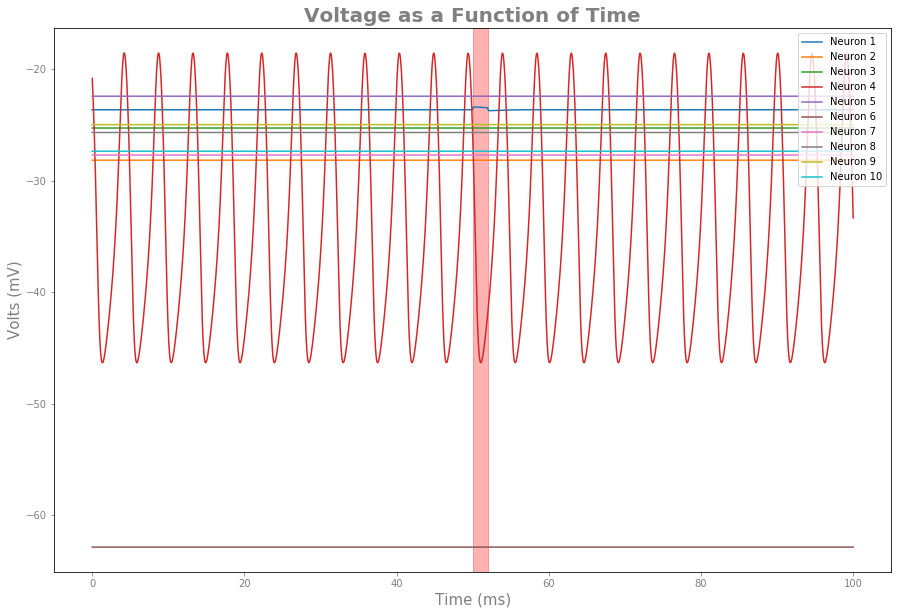

In [36]:
#"x10_18_0.npy"
def read_SC(node, numNodes):
    if numNodes==10:
        my_path = os.getcwd() + r"\\NetworkCouplingParams\\" + "x10_18_0.npy"
        my_array = np.load(my_path)
    else:
        filename = str(numNodes) + "Neurons.npy"
        my_path = os.getcwd() + r"\\NetworkCouplingParams\\" + filename
        my_array = np.load(my_path)
    
    my_string = str(my_array[node,:]) #-1
    #print(node)
    #print(my_string)
    my_string = my_string.replace('\n','')
    for char in my_string:
        if char in "[],\n/;:":
            my_string = my_string.replace(char,'')
    
    my_keys = [val+1 for val in range(numNodes)]
    my_vals = my_string.split()
    my_dict = {}
    count = 0
    for key in my_keys:
        my_dict[key] = my_vals[count]
        count += 1
    
    return my_dict

vI = [50,52,0.1]
updatedCurrent1 = runSim(vI,numNodes=10,plot_BI=True)

Burn in run, looking for NO oscillations


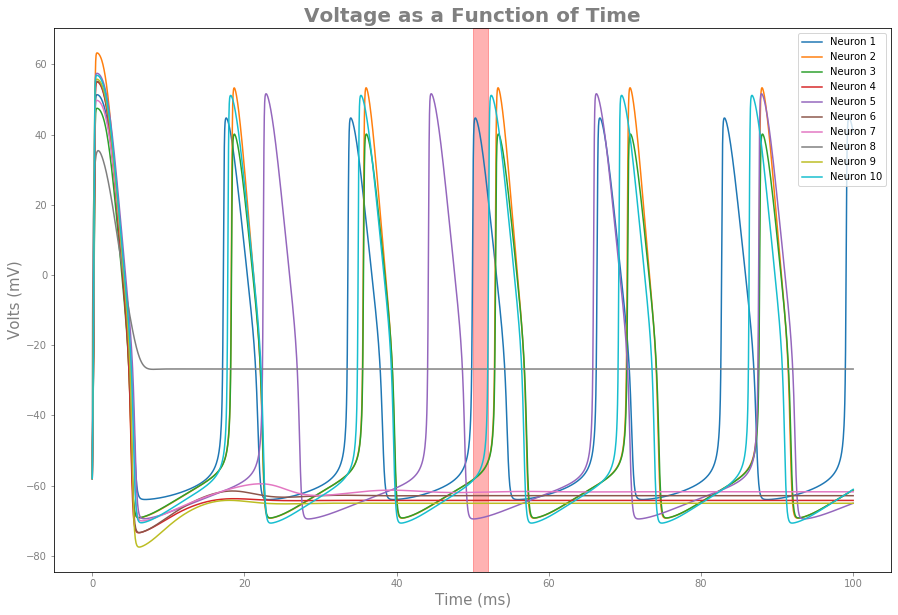

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


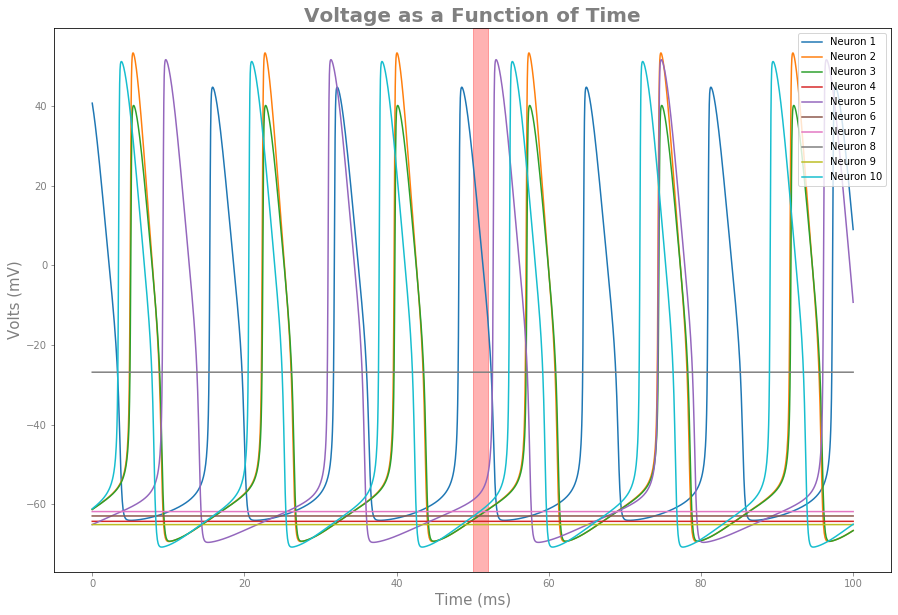

In [38]:
#"x10_90_0.npy"
def read_SC(node, numNodes):
    if numNodes==10:
        my_path = os.getcwd() + r"\\NetworkCouplingParams\\" + "x10_90_0.npy"
        my_array = np.load(my_path)
    else:
        filename = str(numNodes) + "Neurons.npy"
        my_path = os.getcwd() + r"\\NetworkCouplingParams\\" + filename
        my_array = np.load(my_path)
    
    my_string = str(my_array[node,:]) #-1
    #print(node)
    #print(my_string)
    my_string = my_string.replace('\n','')
    for char in my_string:
        if char in "[],\n/;:":
            my_string = my_string.replace(char,'')
    
    my_keys = [val+1 for val in range(numNodes)]
    my_vals = my_string.split()
    my_dict = {}
    count = 0
    for key in my_keys:
        my_dict[key] = my_vals[count]
        count += 1
    
    return my_dict

vI = [50,52,0.1]
updatedCurrent1 = runSim(vI,numNodes=10,plot_BI=True)

Burn in run, looking for NO oscillations


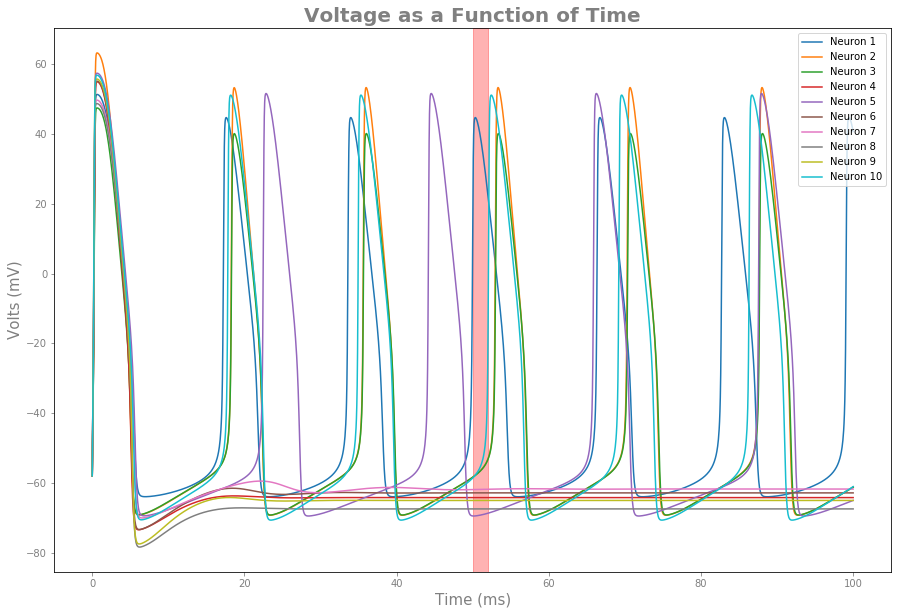

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


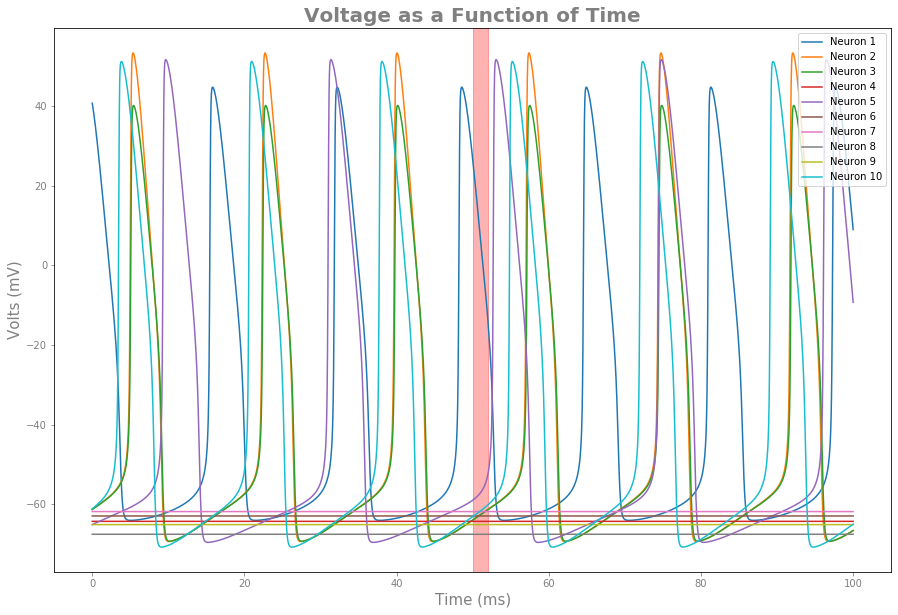

In [37]:
#Just zeros
def read_SC(node, numNodes):
    if numNodes==10:
        my_keys = [key+1 for key in range(10)]
        my_vals = [0]*10
        my_dict = {}
        count = 0
        for key in my_keys:
            my_dict[key] = my_vals[count]
            count += 1
        
        return my_dict
    else:
        filename = str(numNodes) + "Neurons.npy"
        my_path = os.getcwd() + r"\\NetworkCouplingParams\\" + filename
        my_array = np.load(my_path)
    
    my_string = str(my_array[node,:]) #-1
    #print(node)
    #print(my_string)
    my_string = my_string.replace('\n','')
    for char in my_string:
        if char in "[],\n/;:":
            my_string = my_string.replace(char,'')
    
    my_keys = [val+1 for val in range(numNodes)]
    my_vals = my_string.split()
    my_dict = {}
    count = 0
    for key in my_keys:
        my_dict[key] = my_vals[count]
        count += 1
    
    return my_dict

vI = [50,52,0.1]
updatedCurrent1 = runSim(vI,numNodes=10,plot_BI=True)

## Using a WM which lowers values (to avoid dead cells)

Burn in run, looking for NO oscillations


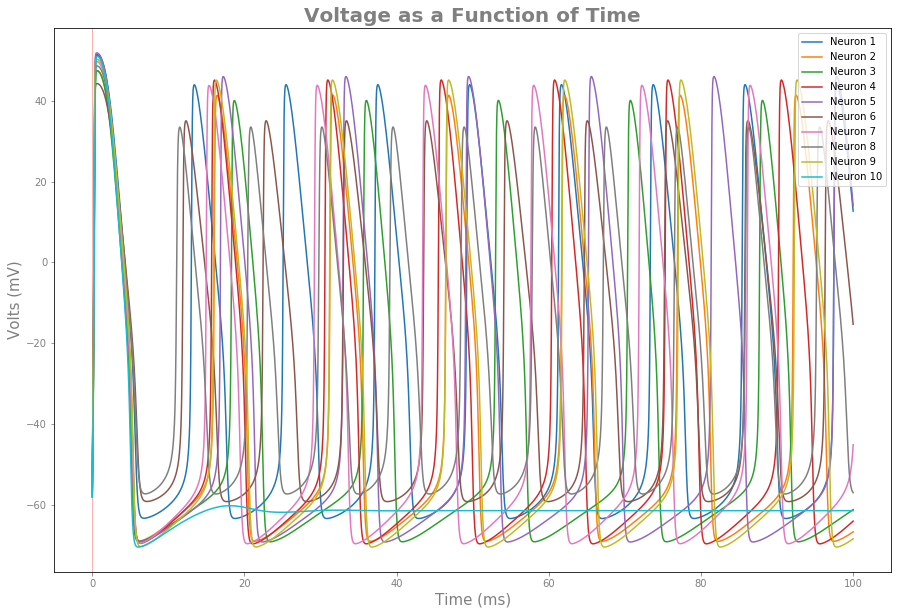

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


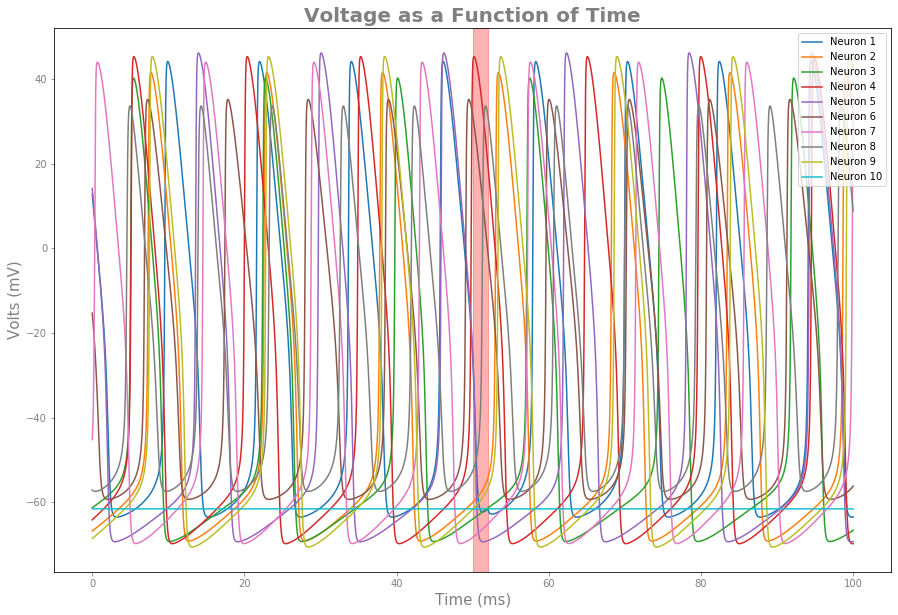

In [41]:
#Just zeros
def read_SC(node, numNodes):
    if numNodes==10:
        my_keys = [key+1 for key in range(10)]
        my_vals = [0]*10
        my_dict = {}
        count = 0
        for key in my_keys:
            my_dict[key] = my_vals[count]
            count += 1
        
        return my_dict
    else:
        filename = str(numNodes) + "Neurons.npy"
        my_path = os.getcwd() + r"\\NetworkCouplingParams\\" + filename
        my_array = np.load(my_path)
    
    my_string = str(my_array[node,:]) #-1
    #print(node)
    #print(my_string)
    my_string = my_string.replace('\n','')
    for char in my_string:
        if char in "[],\n/;:":
            my_string = my_string.replace(char,'')
    
    my_keys = [val+1 for val in range(numNodes)]
    my_vals = my_string.split()
    my_dict = {}
    count = 0
    for key in my_keys:
        my_dict[key] = my_vals[count]
        count += 1
    
    return my_dict

vI = [50,52,0.1]
updatedCurrent1 = runSim(vI,numNodes=10,plot_BI=True)

Burn in run, looking for NO oscillations


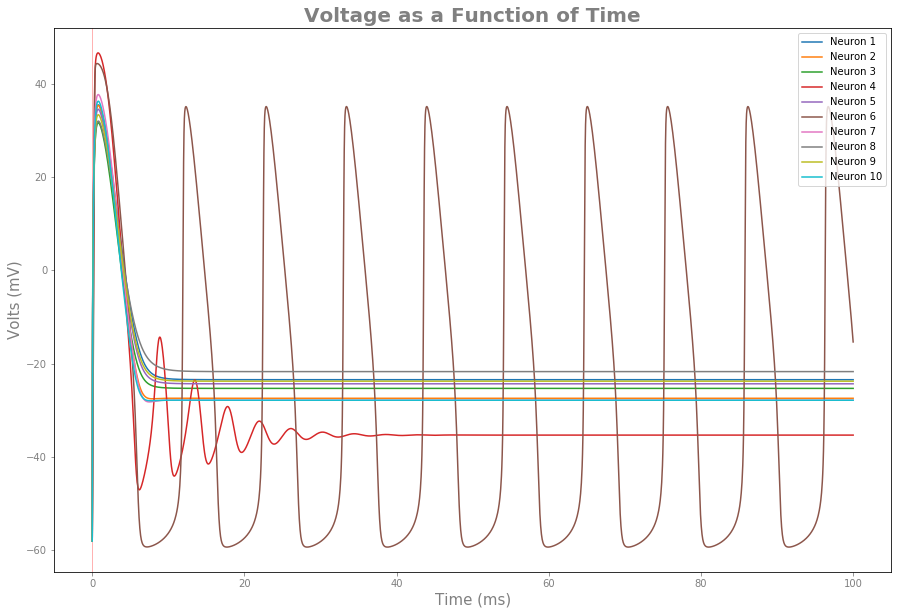

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


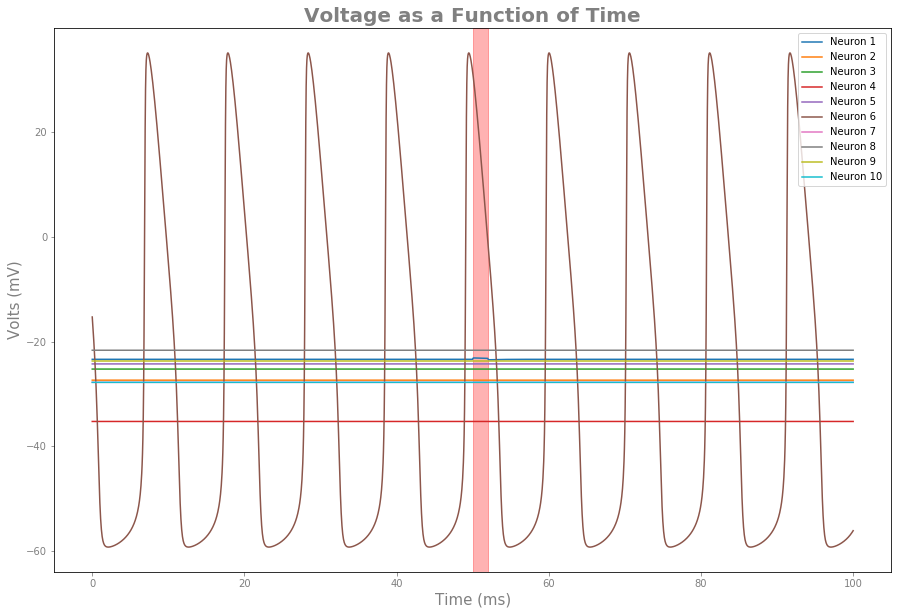

In [42]:
#"x10_18_0.npy"
def read_SC(node, numNodes):
    if numNodes==10:
        my_path = os.getcwd() + r"\\NetworkCouplingParams\\" + "x10_18_0.npy"
        my_array = np.load(my_path)
    else:
        filename = str(numNodes) + "Neurons.npy"
        my_path = os.getcwd() + r"\\NetworkCouplingParams\\" + filename
        my_array = np.load(my_path)
    
    my_string = str(my_array[node,:]) #-1
    #print(node)
    #print(my_string)
    my_string = my_string.replace('\n','')
    for char in my_string:
        if char in "[],\n/;:":
            my_string = my_string.replace(char,'')
    
    my_keys = [val+1 for val in range(numNodes)]
    my_vals = my_string.split()
    my_dict = {}
    count = 0
    for key in my_keys:
        my_dict[key] = my_vals[count]
        count += 1
    
    return my_dict

vI = [50,52,0.1]
updatedCurrent1 = runSim(vI,numNodes=10,plot_BI=True)

## Not 10 Neuron Cases

Burn in run, looking for NO oscillations


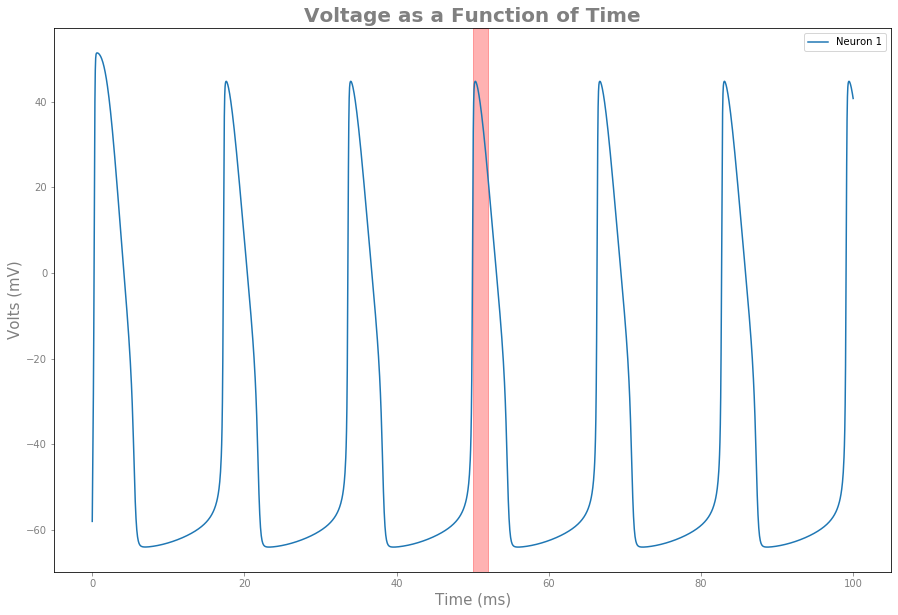

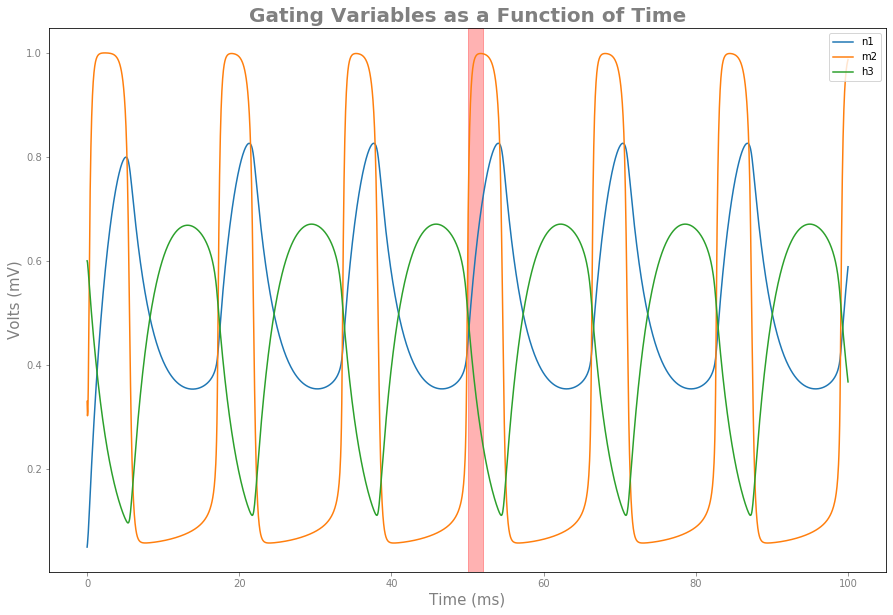

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


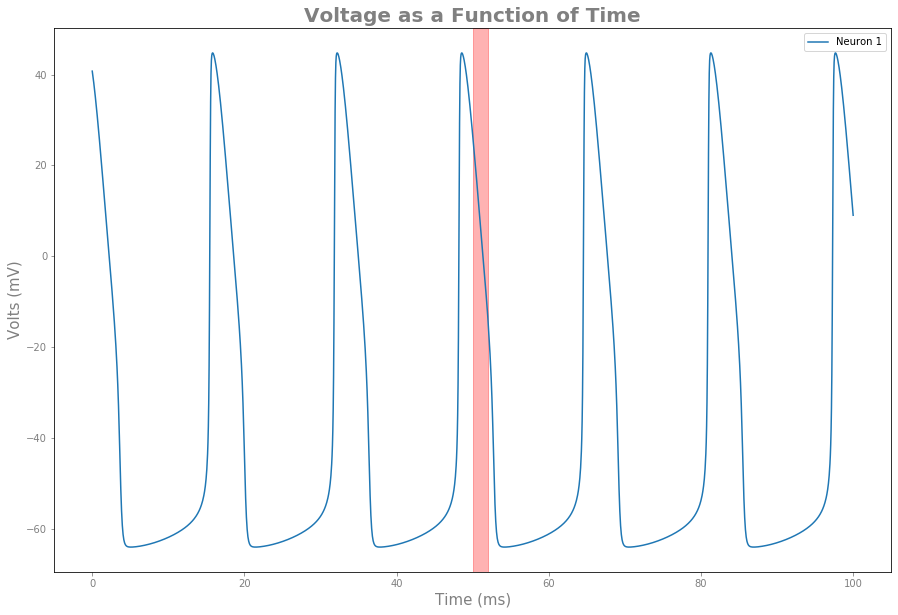

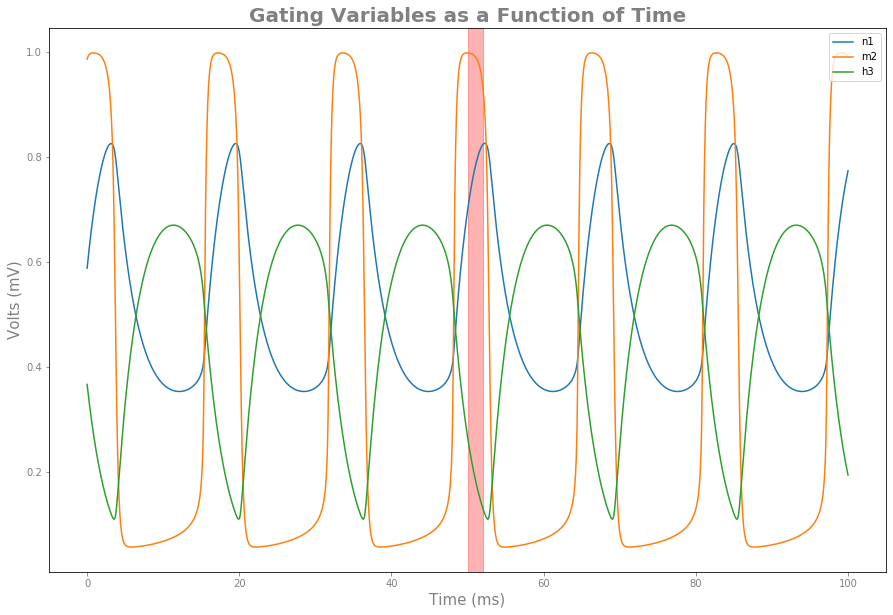

In [33]:
vI = [50,52,0.1]
updatedCurrent1 = runSim(vI,numNodes=1,plot_BI=True,showGVs=True)

Burn in run, looking for NO oscillations


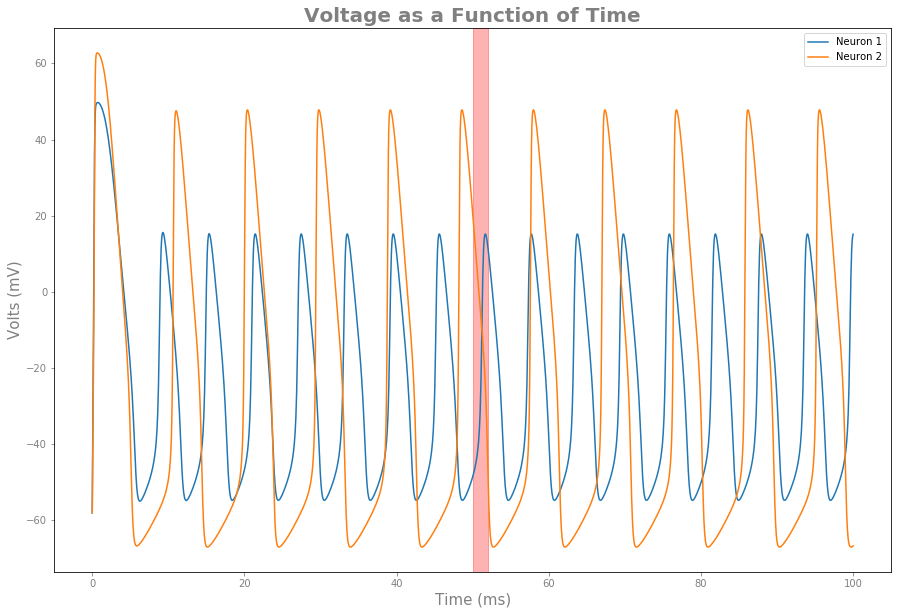

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


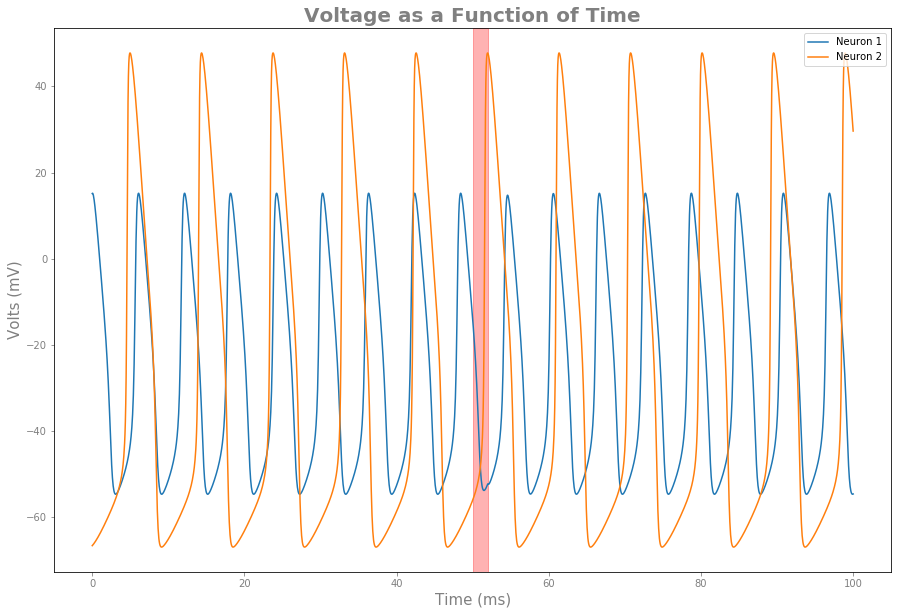

In [34]:
vI = [50,52,0.1]
updatedCurrent1 = runSim(vI,numNodes=2,plot_BI=True)

In [ ]:
vI = [50,52,0.1]
updatedCurrent1 = runSim(vI,numNodes=3,plot_BI=True)

In [ ]:
vI = [50,52,0.1]
updatedCurrent1 = runSim(vI,numNodes=4,plot_BI=True)

In [ ]:
vI = [50,52,0.1]
updatedCurrent1 = runSim(vI,numNodes=5,plot_BI=True)

In [ ]:
vI = [50,52,0.1]
updatedCurrent1 = runSim(vI,numNodes=6,plot_BI=True)

Burn in run, looking for NO oscillations


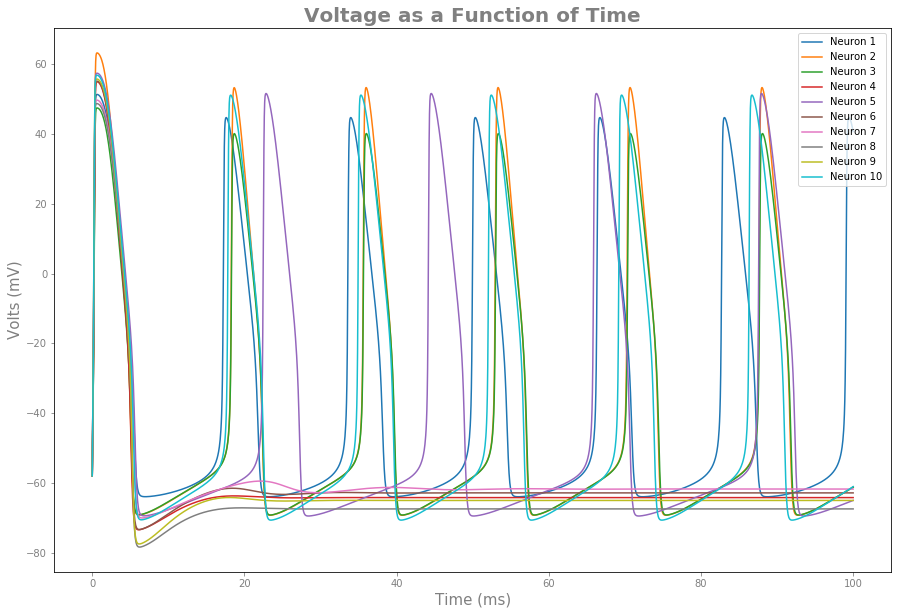

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


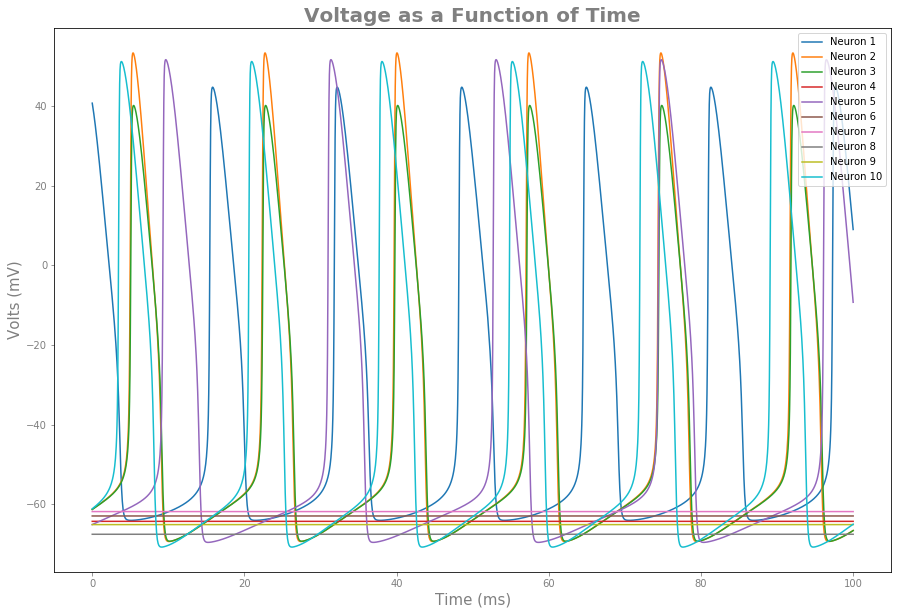

In [70]:
#Run with all zeros (no connections between nodes, purportedly)
vI = [50,52,0.1]
updatedCurrent1 = runSim(vI,numNodes=10,plot_BI=True)

Burn in run, looking for NO oscillations


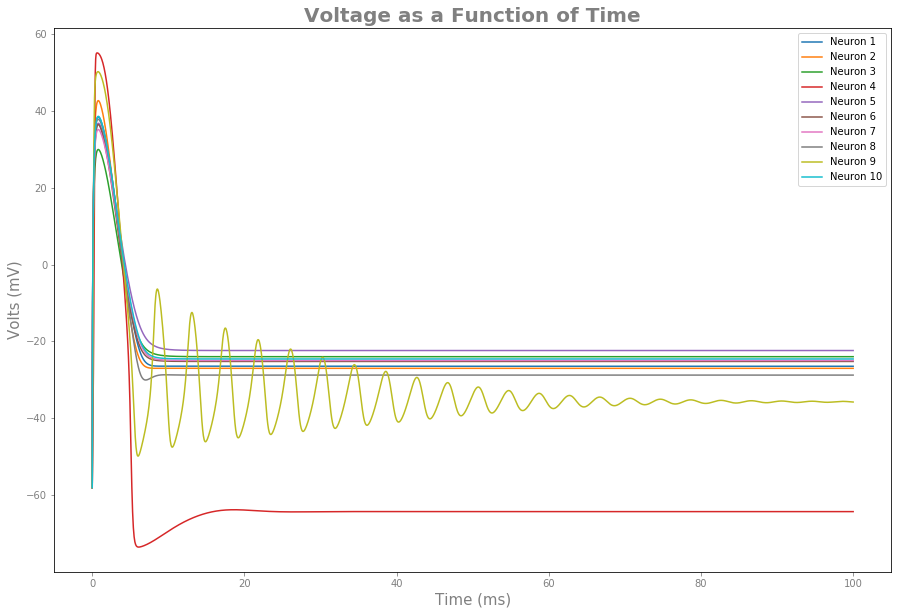

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


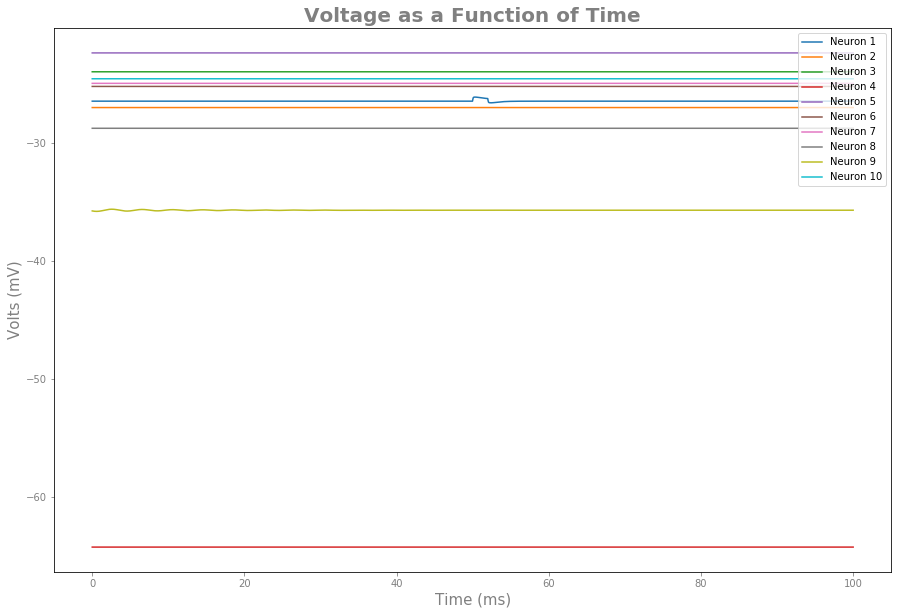

In [78]:
#"x10_18_5.npy"
vI = [50,52,0.1]
updatedCurrent1 = runSim(vI,numNodes=10,plot_BI=True)